<a href="https://colab.research.google.com/github/mervegb/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

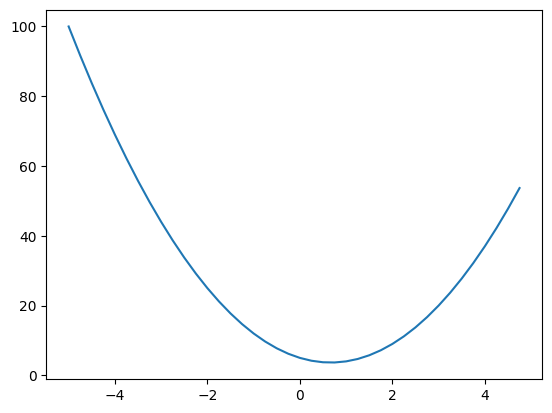

In [5]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [6]:
a = 2.0
b=-3.0
c=10.0
d = a*b +c
print(d)

4.0


In [7]:
h=0.001
a = 2.0
b=-3.0
c=10.0

d1 = a*b +c
c+=h
d2 = a*b +c

print("d1",d1)
print("d2",d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


In [8]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #empty function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  #when you add two numbers the gradient with respect to either input is 1
  #that means if you increase either of the inputs by small amount, the output will increase by the same amount
  def __add__(self, other):
    #if other is instance of value keep, otherwise we'll assume that it's a number like an integer
    other = other if isinstance(other,Value) else Value(other)
    output = Value(self.data + other.data, (self, other),"+")

    def _backward():
      self.grad += 1.0 * output.grad
      other.grad += 1.0 * output.grad

    output._backward = _backward
    return output

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    output = Value(self.data * other.data, (self,other), "*")

    def _backward():
      self.grad += other.data * output.grad
      other.grad += self.data * output.grad

    output._backward = _backward
    return output

  #it defines
  def __rmul__(self,other):
    return self * other

  #self/other
  def __truediv__(self,other):
    return self * other**1

  def __neg__(self):
    return self * -1

  #subtraction (self-other)
  def __sub__(self,other):
    return self + (-other)

  #derivative of x^n with respect to x, where n is a constant
  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    output = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * output.grad
      output._backward = _backward

    return output

  #performs backpropagation
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


  #activation function
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) +1)
    output = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * output.grad

    output._backward = _backward #we are storing the function itself so that we can call it later in backpropagation
    return output

  def exp(self):
    x = self.data
    output = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += output.data * output.grad
    output._backward = _backward

    return output

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0,label='c')
e = a*b; e.label= 'e'
d = a*b + c; d.label='d'
f = Value(-2.0, label='f')
L = d *f; L.label='L'
L

Value(data = -8.0)

In [9]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data = -2.0)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

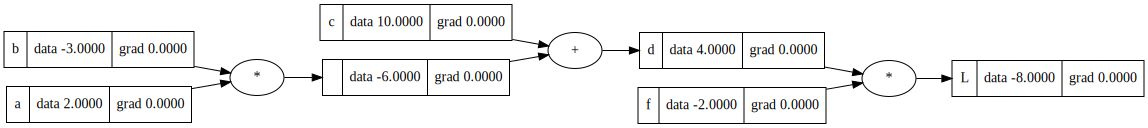

In [11]:
draw_dot(L)

In [12]:
L.grad = 1.0

#dl/dd
#(f(x+h)-f(x))/h
#((d+h)*f - d*f) /h
#(h*f)/h
#f

f.grad = 4.0
d.grad = -2

In [13]:
#dd/dc
#d = c + e
#(f(x+h) - f(x)) /h
#((c+h+e) - (c+e)) /h
#c+h+e-c-e
#h/h = 1.0

#Chain Rule
#dl / dc = (dl / dd) * (dd / dc)


#WANT dl/dc
#KNOW dd/dc
#dl/dc = (dl/dd) * (dd/dc)
c.grad = -2.0
e.grad = -2.0

In [14]:
#dl/de
#dl/da = (dl/de) * (de/da)
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [15]:
a.data += 0.01 * a .grad
b.data += 0.01 * b .grad
c.data += 0.01 * c .grad
f.data += 0.01 * f .grad

e = a*b
d=e+c
L=d*f
print(L.data)

-35.549696


In [16]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0,label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d *f; L.label='L'
  L1 = L.data


  a = Value(2.0+h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label= 'e'
  d = e + c; d.label='d'
  d.data += h
  f = Value(-2.0, label='f')
  L = d *f; L.label='L'
  L2 = L.data


  print((L2-L1)/h)

lol()

#Backpropagation => recursive application of chain rule backwards through the computation graph


4.000000000000448


In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp()
o = (e-1) / (e+1)
#--
o.label = 'o'
o.backward()

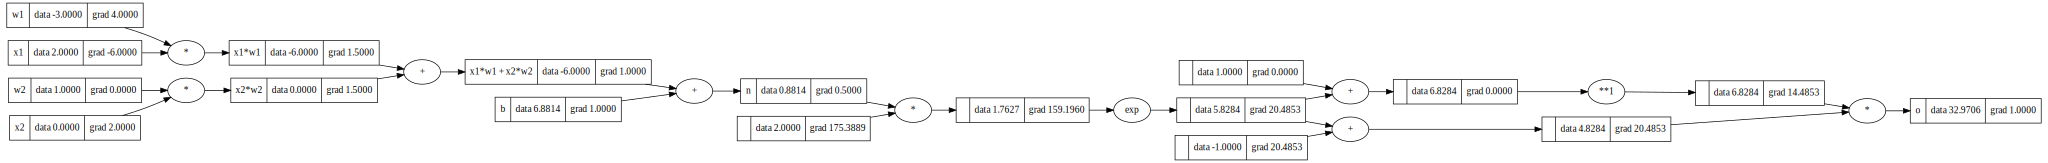

In [33]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
o.grad = 1.0

In [21]:
#o = tanh(n)
#do / dn = 1 - tanh(n)**2
1- o.data**2

-1086.0580079512695

In [22]:
n.grad = 0.5

In [23]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [24]:
x1w1.grad = 0.5
x2w2.grad =0.5

In [25]:
#x2w2 = x2 * w2 forward pass
#if you want to know how change in the weight w2 affects the output of this multiplication
# you want to find the gradient of the loss with respect to w2
x2.grad = w2.data * x2w2.grad

#this expression tells you how small change in the weight w2 will affect the final loss
w2.grad = x2.data * x2w2.grad

#x2.data => represents the value of x2, which is the derivative of the multiplication with respect to w2
#x2w2.grad => represents the derivative of loss with respect to output of multiplication
#w2.grad => overall derivative of the loss with respect to w2

In [26]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [27]:
#when you perform backpropagation, you start computing gradient of the loss function with respect to its inputs
o.grad = 1.0
o._backward()

In [28]:
n._backward()

In [29]:
b._backward()

In [30]:
x1w1x2w2._backward()

In [31]:
x2w2._backward()
x1w1._backward()

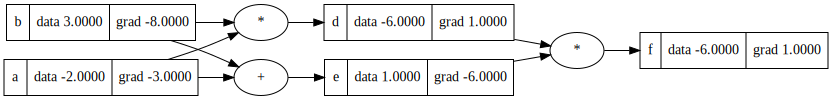

In [32]:
a = Value(-2, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)